In [1]:
import keras
#from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten, BatchNormalization, ReLU

import cv2 
import numpy as np 
from keras import backend as K 

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import *
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from skimage import exposure
from keras.utils.vis_utils import plot_model
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/tfoldNC.zip" 

Archive:  /content/drive/My Drive/tfoldNC.zip
   creating: tfoldNC/
   creating: tfoldNC/fold1/
   creating: tfoldNC/fold1/test/
   creating: tfoldNC/fold1/test/anger/
  inflating: tfoldNC/fold1/test/anger/S010_004_00000019.png  
  inflating: tfoldNC/fold1/test/anger/S011_004_00000021.png  
  inflating: tfoldNC/fold1/test/anger/S014_003_00000030.png  
  inflating: tfoldNC/fold1/test/anger/S022_005_00000032.png  
  inflating: tfoldNC/fold1/test/anger/S026_003_00000015.png  
  inflating: tfoldNC/fold1/test/anger/S028_001_00000024.png  
  inflating: tfoldNC/fold1/test/anger/S029_001_00000019.png  
  inflating: tfoldNC/fold1/test/anger/S032_003_00000017.png  
  inflating: tfoldNC/fold1/test/anger/S034_003_00000027.png  
   creating: tfoldNC/fold1/test/disgust/
  inflating: tfoldNC/fold1/test/disgust/S005_001_00000011.png  
  inflating: tfoldNC/fold1/test/disgust/S011_005_00000020.png  
  inflating: tfoldNC/fold1/test/disgust/S022_006_00000017.png  
  inflating: tfoldNC/fold1/test/disgust/S

In [15]:
batch_size=124
train_sample=512
valid_sample=124
test_sample=124
img_rows,img_cols=48,48
#train_path = 'sorted_set_3_frame_split_8_2_new/train'
#valid_path = 'sorted_set_3_frame_split_8_2_new/val'
#test_path = 'sorted_set_3_frame_split_8_2_new/val'
train_path = 'tfoldNC/fold1/train'
valid_path = 'tfoldNC/fold1/test'
test_path = 'tfoldNC/fold1/test'
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					width_shift_range=0.3,
					height_shift_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_path,
          color_mode='grayscale',
					target_size=(img_rows,img_cols),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							valid_path,
							color_mode='grayscale',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)
test_generator= ImageDataGenerator(rescale=1./255).flow_from_directory(valid_path, 
							color_mode='grayscale',
							target_size=(img_rows,img_cols),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=False)


Found 512 images belonging to 7 classes.
Found 124 images belonging to 7 classes.
Found 124 images belonging to 7 classes.


In [11]:
# model 2 -2.8
img_rows,img_cols=48,48


input_layer = Input(shape=(48, 48, 1))

x = Conv2D(32, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_1_3x3/1')(input_layer)
x=BatchNormalization()(x)
x = Conv2D(32, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_1a_3x3/1')(x)
x=BatchNormalization()(x)
x = MaxPool2D((2, 2), name='max_pool_1_3x3/2')(x)
x=BatchNormalization()(x)


#Block 2A
x1 = Conv2D(64, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x1=BatchNormalization()(x1)
x12 = Conv2D(64, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_2a1_3x3/1')(x1)
x12=BatchNormalization()(x12)
#Block 2B
y1 = Conv2D(64, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
y1=BatchNormalization()(y1)
y12 = Conv2D(64, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_2b1_3x3/1')(y1)
y12=BatchNormalization()(y12)

concat_b2 = concatenate([x, x12, y12], axis=3,name='inception_dense_1')
#trans
t1 = Conv2D(64, (1, 1), padding='same',strides=(1, 1), activation='relu', name='conv_t1_3x3/1')(concat_b2)
t1=BatchNormalization()(t1)
t2 = MaxPool2D((2, 2), name='max_pool_t2_3x3/2')(t1)
t2=BatchNormalization()(t2)
#x=Dropout(0.2)

#Block 3A
x2 = Conv2D(128, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_3a_3x3/1')(t2)
x2=BatchNormalization()(x2)
x22 = Conv2D(128, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_3a1_3x3/1')(x2)
x22=BatchNormalization()(x22)
#Block 3B
y2 = Conv2D(128, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_3b_3x3/1')(t2)
y2=BatchNormalization()(y2)
y22 = Conv2D(128, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_3b1_3x3/1')(y2)
y22=BatchNormalization()(y22)

concat_b3 = concatenate([t2, x22, y22], axis=3,name='inception_dense_2')
#trans
t3 = Conv2D(128, (1, 1), padding='same',strides=(1, 1), activation='relu', name='conv_t3_3x3/1')(concat_b3)
t3=BatchNormalization()(t3)
t4 = MaxPool2D((2, 2), name='max_pool_t4_3x3/2')(t3)
t4=BatchNormalization()(t4)
#x=Dropout(0.2)



#Block 4A
x3 = Conv2D(256, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_4a_3x3/1')(t4)
x3=BatchNormalization()(x3)
x32 = Conv2D(256, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_4a1_3x3/1')(x3)
x32=BatchNormalization()(x32)
#Block 4B
y3 = Conv2D(256, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_4b_3x3/1')(t4)
y3=BatchNormalization()(y3)
y32 = Conv2D(256, (3, 3), padding='same',strides=(1, 1), activation='relu', name='conv_4b1_3x3/1')(y3)
y32=BatchNormalization()(y32)
concat_b4 = concatenate([t4, x32, y32], axis=3,name='inception_dense_4')
#trans
t5 = Conv2D(256, (1, 1), padding='same',strides=(1, 1), activation='relu', name='conv_t5_3x3/1')(concat_b4)
t5=BatchNormalization()(t5)
#t6 = MaxPool2D((2, 2), name='max_pool_t6_3x3/2')(t5)
#t6=BatchNormalization()(t6)
#x=Dropout(0.2)

t8 = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(t5)


# Block-6

xf=Dense(512,activation='relu')(t8)
xf=BatchNormalization()(xf)
xf=Dropout(0.5)(xf)

# Block-6

xf=Dense(256,activation='relu')(xf)
xf=BatchNormalization()(xf)
xf=Dropout(0.5)(xf)

# Block-7

xf=Dense(7,activation='softmax')(xf)
#xf=Dense(2,activation='sigmoid')(xf)
model = Model(input_layer, [xf], name='inception_v1')
model.summary()


Model: "inception_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv_1_3x3/1 (Conv2D)          (None, 48, 48, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 48, 48, 32)  128         ['conv_1_3x3/1[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 conv_1a_3x3/1 (Conv2D)         (None, 48, 48, 32)   9248        ['batch_normalization_

In [16]:
model.load_weights('/content/drive/My Drive/fer_new_vgg/PeerJ_emo_seed_1.hdf5') 

In [17]:
#from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import os
#filepath="/content/drive/My Drive/fer_new_vgg/fold1_jaffe_epochs:{epoch:03d}-accuracy:{val_accuracy:.4f}.hdf5"

filepath="/content/drive/My Drive/fer_new_vgg/PeerJ_CK+_seed_5.hdf5"
checkpoint_dir = os.path.dirname(filepath)


checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=2)

callbacks = [checkpoint]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

epochs=150

history=model.fit(
                train_generator,
                steps_per_epoch=train_sample//batch_size+1,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=validation_generator,
                validation_steps=valid_sample//batch_size)

Epoch 1/150
5/5 [==============================] - ETA: 0s - loss: 1.6434 - accuracy: 0.5605
Epoch 1: val_accuracy improved from -inf to 0.70161, saving model to /content/drive/My Drive/fer_new_vgg/PeerJ_CK+_seed_5.hdf5
5/5 [==============================] - 7s 1s/step - loss: 1.6434 - accuracy: 0.5605 - val_loss: 1.4300 - val_accuracy: 0.7016
Epoch 2/150
5/5 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.6875
Epoch 2: val_accuracy improved from 0.70161 to 0.77419, saving model to /content/drive/My Drive/fer_new_vgg/PeerJ_CK+_seed_5.hdf5
5/5 [==============================] - 3s 512ms/step - loss: 0.9803 - accuracy: 0.6875 - val_loss: 1.2087 - val_accuracy: 0.7742
Epoch 3/150
5/5 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.8301
Epoch 3: val_accuracy improved from 0.77419 to 0.80645, saving model to /content/drive/My Drive/fer_new_vgg/PeerJ_CK+_seed_5.hdf5
5/5 [==============================] - 3s 509ms/step - loss: 0.5766 - accuracy:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

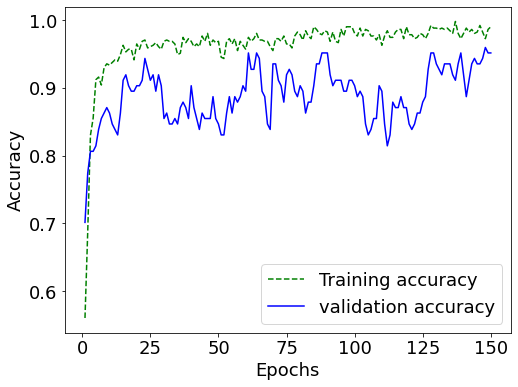

In [18]:
from google.colab import files
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,151)
plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 18
plt.plot(epochs, loss_train, 'g--', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
#plt.title('Training and Validation accuracy')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Accuracy',fontsize=18)
plt.legend()
plt.savefig('acc_ck+_2013.png')
files.download("acc_ck+_2013.png")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

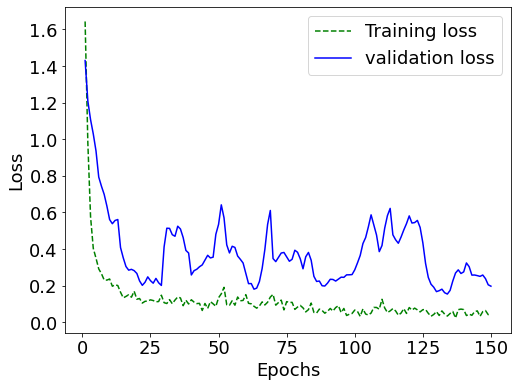

In [23]:
from google.colab import files
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,151)
plt.figure(figsize=(8,6))
plt.plot(epochs, loss_train, 'g--', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
#plt.title('Training and Validation accuracy')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.legend()
plt.savefig('loss_CK+_2013.png')
files.download("loss_CK+_2013.png")
plt.show()

In [21]:
model.load_weights('/content/drive/My Drive/fer_new_vgg/PeerJ_CK+_seed_5.hdf5') 

In [24]:
predictions = model.predict(test_generator, steps=test_sample//batch_size, verbose=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

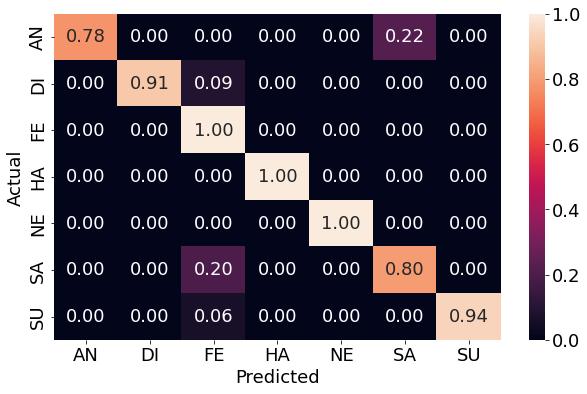

In [25]:
cm_plot_labels = ['AN',
 'DI',
 'FE',
 'HA',
 'NE',
 'SA',
 'SU']
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,6))
p=sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
p.set_xticklabels(p.get_xmajorticklabels(), fontsize = 18)
p.set_yticklabels(p.get_ymajorticklabels(), fontsize = 18)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.savefig('conf_CK+_2013.png')
files.download("conf_CK+_2013.png")
plt.show(block=False)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions.argmax(axis=1),target_names=cm_plot_labels,digits=4))

              precision    recall  f1-score   support

          AN     1.0000    0.7778    0.8750         9
          DI     1.0000    0.9091    0.9524        11
          FE     0.6250    1.0000    0.7692         5
          HA     1.0000    1.0000    1.0000        13
          NE     1.0000    1.0000    1.0000        65
          SA     0.6667    0.8000    0.7273         5
          SU     1.0000    0.9375    0.9677        16

    accuracy                         0.9597       124
   macro avg     0.8988    0.9178    0.8988       124
weighted avg     0.9714    0.9597    0.9622       124

